# Plots with confidence interval

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import json
import numpy as np
from pbo.utils.confidence_interval import confidence_interval


parameters = json.load(open("parameters.json"))

max_bellman_iterations = 5
max_bellman_iterations_validation = max_bellman_iterations + 20
seeds = range(21, 41)
n_states = parameters["n_states"]
n_actions = 2
n_weights = parameters["n_weights"]
n_repetitions = parameters["n_repetitions"]
ticks_freqs = {"2": 2, "5": 5, "15":5}
ticks_freq = ticks_freqs[str(max_bellman_iterations)]

## Extract optimal

In [2]:
optimal_q = np.load(f"figures/data/optimal/Q.npy")
optimal_v = np.load(f"figures/data/optimal/V.npy")

pbo_optimal_q = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_Q.npy")
pbo_optimal_bi = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_BI.npy")
pbo_optimal_v = np.load(f"figures/data/PBO_optimal/{max_bellman_iterations}_V.npy")

pbo_optimal_q_mean = np.sqrt(np.mean(np.square(pbo_optimal_q - optimal_q), axis=(1, 2)))
pbo_optimal_v_mean = np.sqrt(np.mean(np.square(pbo_optimal_v - optimal_v), axis=1))
pbo_optimal_bi_mean = np.sqrt(np.mean(np.square(pbo_optimal_bi[:-1] - pbo_optimal_q[1:]), axis=(1, 2)))

## Investigation on the number of weights

In [3]:
n_weights_list = [20, 50, 100]
n_weights_colors = ["orange", "blue", "green"]

### Extract data

In [4]:
pbo_linear_q_n_weights = np.zeros((len(n_weights_list), len(seeds), max_bellman_iterations_validation + 2, n_states, n_actions))
pbo_linear_bi_n_weights = np.zeros((len(n_weights_list), len(seeds), max_bellman_iterations_validation + 2, n_states, n_actions))
pbo_linear_v_n_weights = np.zeros((len(n_weights_list), len(seeds), max_bellman_iterations_validation + 2, n_states))

for idx_n_weights, n_weights_ in enumerate(n_weights_list):
    for idx_seed, seed in enumerate(seeds):
        pbo_linear_q_n_weights[idx_n_weights, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_Q_{n_weights_}_{seed}.npy")
        pbo_linear_bi_n_weights[idx_n_weights, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_BI_{n_weights_}_{seed}.npy")
        pbo_linear_v_n_weights[idx_n_weights, idx_seed] = np.load(f"figures/data/PBO_linear/{max_bellman_iterations}_V_{n_weights_}_{seed}.npy")

### Distance to the optimal Q functions

In [5]:
pbo_linear_q_mean_n_weights = np.zeros((len(n_weights_list), max_bellman_iterations_validation + 2))
pbo_linear_q_confidence_interval_n_weights = np.zeros((len(n_weights_list), 2, max_bellman_iterations_validation + 2))

for idx_n_weights in range(len(n_weights_list)):
    pbo_linear_q_mean_n_weights[idx_n_weights] = np.sqrt(np.mean(np.square(pbo_linear_q_n_weights[idx_n_weights] - optimal_q), axis=(2, 3))).mean(axis=0)
    pbo_linear_q_std_n_weights = np.sqrt(np.mean(np.square(pbo_linear_q_n_weights[idx_n_weights] - optimal_q), axis=(2, 3))).std(axis=0)
    pbo_linear_q_confidence_interval_n_weights[idx_n_weights] = confidence_interval(pbo_linear_q_mean_n_weights[idx_n_weights], pbo_linear_q_std_n_weights, len(seeds))

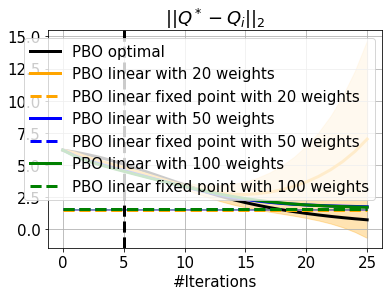

In [6]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_q_mean, label="PBO optimal", color="black")

for idx_n_weights, n_weights_ in enumerate(n_weights_list):
    plt.plot(iterations_validation, pbo_linear_q_mean_n_weights[idx_n_weights, :-1], label=f"PBO linear with {n_weights_} weights", color=n_weights_colors[idx_n_weights])
    plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval_n_weights[idx_n_weights, 0, :-1], pbo_linear_q_confidence_interval_n_weights[idx_n_weights, 1, :-1], color=n_weights_colors[idx_n_weights], alpha=0.3)

    plt.hlines(pbo_linear_q_mean_n_weights[idx_n_weights, -1], 0, max_bellman_iterations_validation, color=n_weights_colors[idx_n_weights], linestyle="--", label=f"PBO linear fixed point with {n_weights_} weights")
    plt.fill_between(iterations_validation, pbo_linear_q_confidence_interval_n_weights[idx_n_weights, 0, -1], pbo_linear_q_confidence_interval_n_weights[idx_n_weights, 1, -1], color=n_weights_colors[idx_n_weights], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$|| Q^* - Q_i ||_2$")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_weights_distance_to_optimal_Q_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distances with the optimal V function

In [7]:
pbo_linear_v_mean_n_weights = np.zeros((len(n_weights_list), max_bellman_iterations_validation + 2))
pbo_linear_v_confidence_interval_n_weights = np.zeros((len(n_weights_list), 2, max_bellman_iterations_validation + 2))

for idx_n_weights in range(len(n_weights_list)):
    pbo_linear_v_mean_n_weights[idx_n_weights] = np.sqrt(np.mean(np.square(pbo_linear_v_n_weights[idx_n_weights] - optimal_v), axis=2)).mean(axis=0)
    pbo_linear_v_std_n_weights = np.sqrt(np.mean(np.square(pbo_linear_v_n_weights[idx_n_weights] - optimal_v), axis=2)).std(axis=0)
    pbo_linear_v_confidence_interval_n_weights[idx_n_weights] = confidence_interval(pbo_linear_v_mean_n_weights[idx_n_weights], pbo_linear_v_std_n_weights, len(seeds))

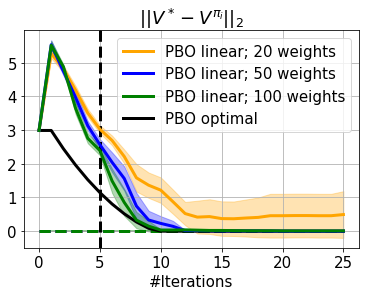

In [8]:
import matplotlib.pyplot as plt

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

for idx_n_weights, n_weights_ in enumerate(n_weights_list):
    plt.plot(iterations_validation, pbo_linear_v_mean_n_weights[idx_n_weights, :-1], label=f"PBO linear; {n_weights_} weights", color=n_weights_colors[idx_n_weights], zorder=7)
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_n_weights[idx_n_weights, 0, :-1], pbo_linear_v_confidence_interval_n_weights[idx_n_weights, 1, :-1], color=n_weights_colors[idx_n_weights], alpha=0.3)

    plt.hlines(pbo_linear_v_mean_n_weights[idx_n_weights, -1], 0, max_bellman_iterations_validation, color=n_weights_colors[idx_n_weights], linestyle="--", zorder=3)
    plt.fill_between(iterations_validation, pbo_linear_v_confidence_interval_n_weights[idx_n_weights, 0, -1], pbo_linear_v_confidence_interval_n_weights[idx_n_weights, 1, -1], color=n_weights_colors[idx_n_weights], alpha=0.3)

plt.plot(iterations_validation, pbo_optimal_v_mean, label="PBO optimal", color="black", zorder=4)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$ || V^* - V^{\pi_i} ||_2 $")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_weights_distance_to_optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to the optimal Bellman iteration

In [9]:
pbo_linear_bi_mean_n_weights = np.zeros((len(n_weights_list), max_bellman_iterations_validation))
pbo_linear_bi_confidence_interval_n_weights = np.zeros((len(n_weights_list), 2, max_bellman_iterations_validation))

pbo_linear_bi_fixed_point_mean_n_weights = np.zeros(len(n_weights_list))
pbo_linear_bi_fixed_point_confidence_interval_n_weights = np.zeros((len(n_weights_list), 2, 1))

for idx_n_weights in range(len(n_weights_list)):
    pbo_linear_bi_mean_n_weights[idx_n_weights] = np.sqrt(np.mean(np.square(pbo_linear_bi_n_weights[idx_n_weights, :, :-2] - pbo_linear_q_n_weights[idx_n_weights, :, 1:-1]), axis=(2, 3))).mean(axis=0)
    pbo_linear_bi_std_n_weights = np.sqrt(np.mean(np.square(pbo_linear_bi_n_weights[idx_n_weights, :, :-2] - pbo_linear_q_n_weights[idx_n_weights, :, 1:-1]), axis=(2, 3))).std(axis=0)
    pbo_linear_bi_confidence_interval_n_weights[idx_n_weights] = confidence_interval(pbo_linear_bi_mean_n_weights[idx_n_weights], pbo_linear_bi_std_n_weights, len(seeds))

    pbo_linear_bi_fixed_point_mean_n_weights[idx_n_weights] = np.sqrt(np.mean(np.square(pbo_linear_bi_n_weights[idx_n_weights, :, -1] - pbo_linear_q_n_weights[idx_n_weights, :, -1]), axis=(1, 2))).mean(axis=0)
    pbo_linear_bi_fixed_point_std_n_weights = np.sqrt(np.mean(np.square(pbo_linear_bi_n_weights[idx_n_weights, :, -1] - pbo_linear_q_n_weights[idx_n_weights, :, -1]), axis=(1, 2))).std(axis=0)
    pbo_linear_bi_fixed_point_confidence_interval_n_weights[idx_n_weights] = confidence_interval([pbo_linear_bi_fixed_point_mean_n_weights[idx_n_weights]], [pbo_linear_bi_fixed_point_std_n_weights], len(seeds))

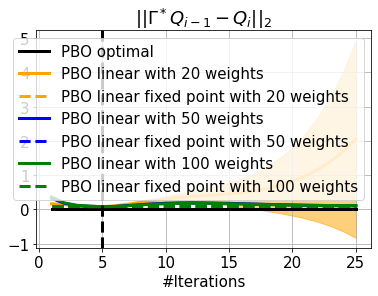

In [10]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(1, max_bellman_iterations + 1)
iterations_validation = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_bi_mean, label="PBO optimal", color="black")

for idx_n_weights, n_weights_ in enumerate(n_weights_list):
    plt.plot(iterations_validation, pbo_linear_bi_mean_n_weights[idx_n_weights], label=f"PBO linear with {n_weights_} weights", color=n_weights_colors[idx_n_weights])
    plt.fill_between(iterations_validation, pbo_linear_bi_confidence_interval_n_weights[idx_n_weights, 0], pbo_linear_bi_confidence_interval_n_weights[idx_n_weights, 1], color=n_weights_colors[idx_n_weights], alpha=0.3)

    plt.hlines(pbo_linear_bi_fixed_point_mean_n_weights[idx_n_weights], 1, max_bellman_iterations_validation, color=n_weights_colors[idx_n_weights], linestyle="--", label=f"PBO linear fixed point with {n_weights_} weights")
    plt.fill_between(iterations_validation, pbo_linear_bi_confidence_interval_n_weights[idx_n_weights, 0], pbo_linear_bi_confidence_interval_n_weights[idx_n_weights, 1], color=n_weights_colors[idx_n_weights], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_2$")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_weights_distance_to_optimal_BI_{max_bellman_iterations}.pdf", bbox_inches='tight')

## Investigation on the number of repetitions

In [11]:
n_repetitions_list = [2, 5, 10]
n_repetitions_colors = ["orange", "blue", "green"]

### Extract data

In [12]:
pbo_max_linear_q_n_repetitions = np.zeros((len(n_repetitions_list), len(seeds), max_bellman_iterations_validation + 1, n_states, n_actions))
pbo_max_linear_bi_n_repetitions = np.zeros((len(n_repetitions_list), len(seeds), max_bellman_iterations_validation + 1, n_states, n_actions))
pbo_max_linear_v_n_repetitions = np.zeros((len(n_repetitions_list), len(seeds), max_bellman_iterations_validation + 1, n_states))

for idx_n_repetitions, n_repetitions_ in enumerate(n_repetitions_list):
    for idx_seed, seed in enumerate(seeds):
        pbo_max_linear_q_n_repetitions[idx_n_repetitions, idx_seed] = np.load(f"figures/data/PBO_max_linear/{max_bellman_iterations}_Q_{n_repetitions_}_{seed}.npy")
        pbo_max_linear_bi_n_repetitions[idx_n_repetitions, idx_seed] = np.load(f"figures/data/PBO_max_linear/{max_bellman_iterations}_BI_{n_repetitions_}_{seed}.npy")
        pbo_max_linear_v_n_repetitions[idx_n_repetitions, idx_seed] = np.load(f"figures/data/PBO_max_linear/{max_bellman_iterations}_V_{n_repetitions}_{seed}.npy")

### Distance to the optimal Q functions

In [13]:
pbo_max_linear_q_mean_n_repetitions = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation + 1))
pbo_max_linear_q_confidence_interval_n_repetitions = np.zeros((len(n_repetitions_list), 2, max_bellman_iterations_validation + 1))

for idx_n_repetitions in range(len(n_repetitions_list)):
    pbo_max_linear_q_mean_n_repetitions[idx_n_repetitions] = np.sqrt(np.mean(np.square(pbo_max_linear_q_n_repetitions[idx_n_repetitions] - optimal_q), axis=(2, 3))).mean(axis=0)
    pbo_max_linear_q_std_n_repetitions = np.sqrt(np.mean(np.square(pbo_max_linear_q_n_repetitions[idx_n_repetitions] - optimal_q), axis=(2, 3))).std(axis=0)
    pbo_max_linear_q_confidence_interval_n_repetitions[idx_n_repetitions] = confidence_interval(pbo_max_linear_q_mean_n_repetitions[idx_n_repetitions], pbo_max_linear_q_std_n_repetitions, len(seeds))

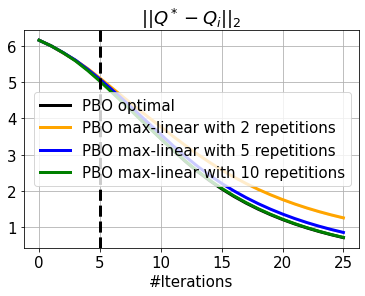

In [14]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_q_mean, label="PBO optimal", color="black")

for idx_n_repetitions, n_repetitions_ in enumerate(n_repetitions_list):
    plt.plot(iterations_validation, pbo_max_linear_q_mean_n_repetitions[idx_n_repetitions], label=f"PBO max-linear with {n_repetitions_} repetitions", color=n_repetitions_colors[idx_n_repetitions])
    plt.fill_between(iterations_validation, pbo_max_linear_q_confidence_interval_n_repetitions[idx_n_repetitions, 0], pbo_max_linear_q_confidence_interval_n_repetitions[idx_n_repetitions, 1], color=n_repetitions_colors[idx_n_repetitions], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$|| Q^* - Q_i ||_2$")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_repetitions_distance_to_optimal_Q_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distances with the optimal V function

In [15]:
pbo_max_linear_v_mean_n_repetitions = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation + 1))
pbo_max_linear_v_confidence_interval_n_repetitions = np.zeros((len(n_repetitions_list), 2, max_bellman_iterations_validation + 1))

for idx_n_repetitions in range(len(n_repetitions_list)):
    pbo_max_linear_v_mean_n_repetitions[idx_n_repetitions] = np.sqrt(np.mean(np.square(pbo_max_linear_v_n_repetitions[idx_n_repetitions] - optimal_v), axis=2)).mean(axis=0)
    pbo_max_linear_v_std_n_repetitions = np.sqrt(np.mean(np.square(pbo_max_linear_v_n_repetitions[idx_n_repetitions] - optimal_v), axis=2)).std(axis=0)
    pbo_max_linear_v_confidence_interval_n_repetitions[idx_n_repetitions] = confidence_interval(pbo_max_linear_v_mean_n_repetitions[idx_n_repetitions], pbo_max_linear_v_std_n_repetitions, len(seeds))

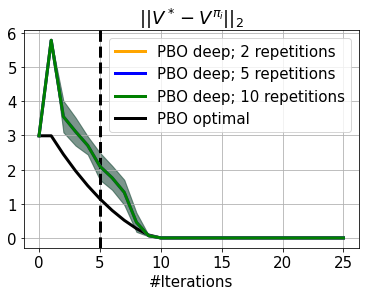

In [16]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(max_bellman_iterations + 1)
iterations_validation = range(max_bellman_iterations_validation + 1)

for idx_n_repetitions, n_repetitions_ in enumerate(n_repetitions_list):
    plt.plot(iterations_validation, pbo_max_linear_v_mean_n_repetitions[idx_n_repetitions], label=f"PBO deep; {n_repetitions_} repetitions", color=n_repetitions_colors[idx_n_repetitions], zorder=8)
    plt.fill_between(iterations_validation, pbo_max_linear_v_confidence_interval_n_repetitions[idx_n_repetitions, 0], pbo_max_linear_v_confidence_interval_n_repetitions[idx_n_repetitions, 1], color=n_repetitions_colors[idx_n_repetitions], alpha=0.3)

plt.plot(iterations_validation, pbo_optimal_v_mean, label="PBO optimal", color="black", zorder=4)

plt.axvline(max_bellman_iterations, color="black", linestyle="--", zorder=2)
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$ || V^* - V^{\pi_i} ||_2 $")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_repetitions_distance_to_optimal_V_{max_bellman_iterations}.pdf", bbox_inches='tight')

### Distance to the optimal Bellman iteration

In [17]:
pbo_max_linear_bi_mean_n_repetitions = np.zeros((len(n_repetitions_list), max_bellman_iterations_validation))
pbo_max_linear_bi_confidence_interval_n_repetitions = np.zeros((len(n_repetitions_list), 2, max_bellman_iterations_validation))

for idx_n_repetitions in range(len(n_repetitions_list)):
    pbo_max_linear_bi_mean_n_repetitions[idx_n_repetitions] = np.sqrt(np.mean(np.square(pbo_max_linear_bi_n_repetitions[idx_n_weights, :, :-1] - pbo_max_linear_q_n_repetitions[idx_n_repetitions, :, 1:]), axis=(2, 3))).mean(axis=0)
    pbo_max_linear_bi_std_n_repetitions = np.sqrt(np.mean(np.square(pbo_max_linear_bi_n_repetitions[idx_n_repetitions, :, :-1] - pbo_max_linear_q_n_repetitions[idx_n_repetitions, :, 1:]), axis=(2, 3))).std(axis=0)
    pbo_max_linear_bi_confidence_interval_n_repetitions[idx_n_repetitions] = confidence_interval(pbo_max_linear_bi_mean_n_repetitions[idx_n_repetitions], pbo_max_linear_bi_std_n_repetitions, len(seeds))

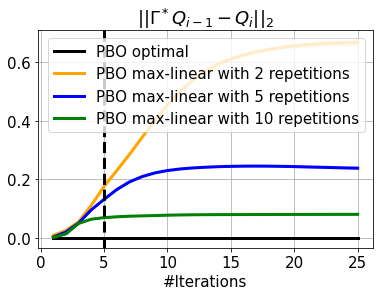

In [18]:
import matplotlib.pyplot as plt 

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(1, max_bellman_iterations + 1)
iterations_validation = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations_validation, pbo_optimal_bi_mean, label="PBO optimal", color="black")

for idx_n_repetitions, n_repetitions_ in enumerate(n_repetitions_list):
    plt.plot(iterations_validation, pbo_max_linear_bi_mean_n_repetitions[idx_n_repetitions], label=f"PBO max-linear with {n_repetitions_} repetitions", color=n_repetitions_colors[idx_n_repetitions])
    plt.fill_between(iterations_validation, pbo_max_linear_bi_confidence_interval_n_repetitions[idx_n_repetitions, 0], pbo_max_linear_bi_confidence_interval_n_repetitions[idx_n_repetitions, 1], color=n_repetitions_colors[idx_n_repetitions], alpha=0.3)

plt.axvline(max_bellman_iterations, color="black", linestyle="--")
plt.xticks(range(0, max_bellman_iterations_validation + 1, ticks_freq))
plt.xlabel("#Iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_2$")
plt.legend()
plt.grid(zorder=0)
_ = plt.savefig(f"figures/n_repetitions_distance_to_optimal_BI_{max_bellman_iterations}.pdf", bbox_inches='tight')